In [1]:
import os
os.chdir('/home/jupyter-nafisha/normal-abnormal-chexagent-attention-loss/main')

In [2]:
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
from dataset import CXR_dataset
from transformers import AutoModel, AutoProcessor, AutoConfig
from model import CheXagentSigLIPBinary
from utils import train_one_epoch, validate

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
csv_path = '/home/jupyter-nafisha/normal-abnormal-chexagent-attention-loss/CSV/val.csv'
# img_dir = '/home/jupyter-nafisha/Data/data_v3_CLAHE/'
img_dir = ''

train_dataset = CXR_dataset(
    csv_path,
    img_dir,
    # train_transforms
)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


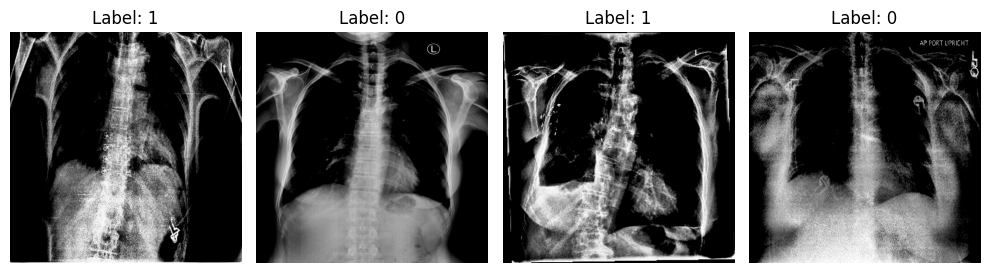

In [5]:
import matplotlib.pyplot as plt
import torch

for images, label, att_gt, _, image_path in train_loader:
    break  

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")
# print(image_path)
plt.tight_layout()
plt.show()

In [6]:
att_gt.shape

torch.Size([4, 1024])

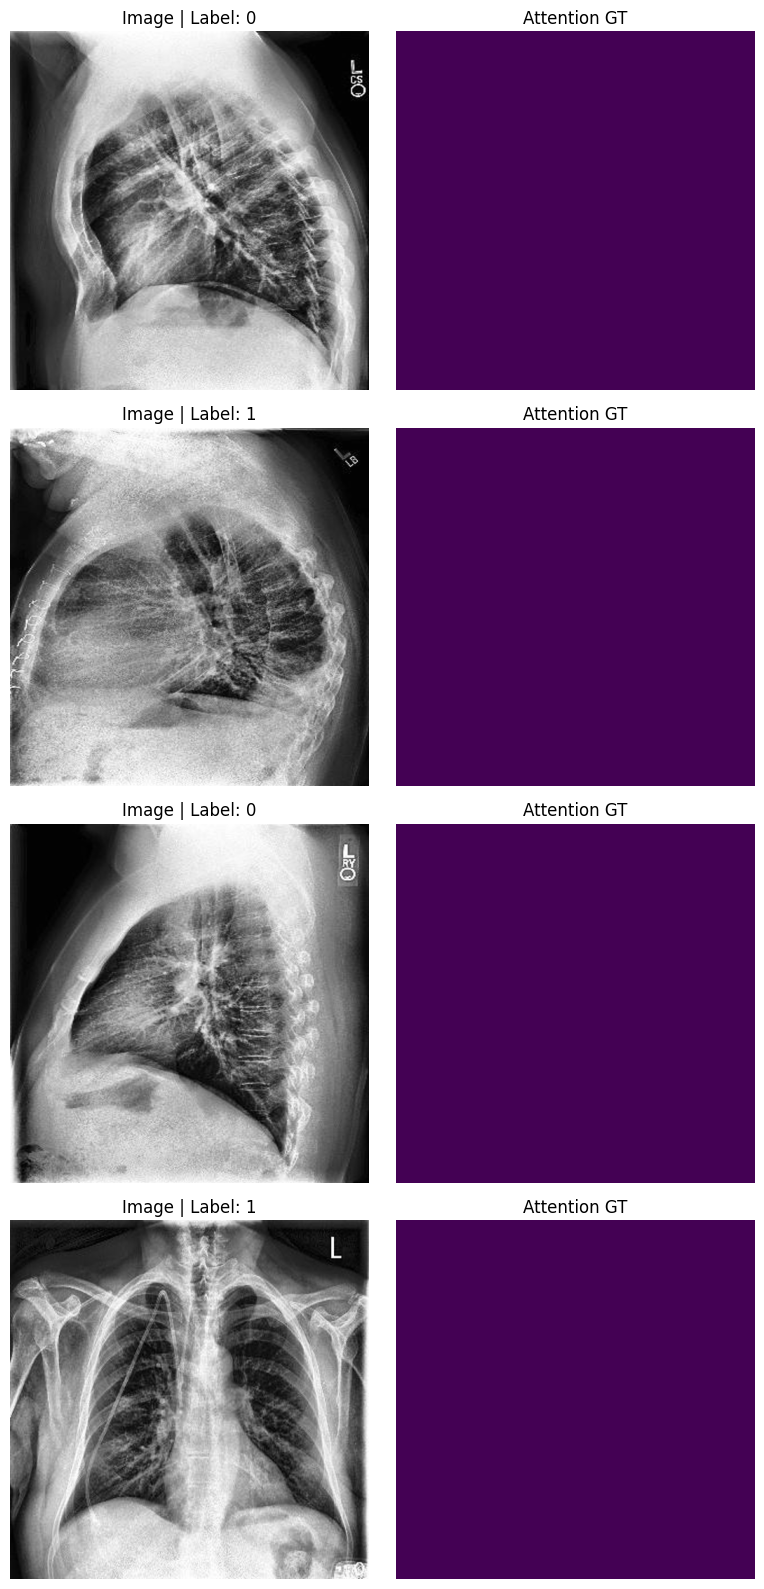

In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

for images, labels, att_gt, _, _ in train_loader:
    break

fig, axes = plt.subplots(4, 2, figsize=(8, 16))

grid_size = 32
img_size = 512

for i in range(4):

    # ----- Image -----
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Image | Label: {labels[i].item()}")

    # ----- Attention GT -----
    att_map = att_gt[i].reshape(grid_size, grid_size)

    att_map = F.interpolate(
        att_map.unsqueeze(0).unsqueeze(0),
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False
    ).squeeze().cpu().numpy()

    axes[i, 1].imshow(att_map)
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Attention GT")

plt.tight_layout()
plt.show()

In [27]:
import json

MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"

processor = AutoProcessor.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

In [80]:
def bbox_to_attention(json_path, image_width, image_height, grid_size=32):

    with open(json_path, "r") as f:
        json_data = json.load(f)

    print(json_data)
    
    objects = json_data['objects']

    if len(objects) == 0:
        return torch.zeros(grid_size * grid_size), False

    attn = torch.zeros(grid_size * grid_size)

    for ann in objects:

        x_min, y_min = ann["points"]["exterior"][0]
        x_max, y_max = ann["points"]["exterior"][1]

        # Normalize 
        x1 = x_min / image_width
        y1 = y_min / image_height
        x2 = x_max / image_width
        y2 = y_max / image_height

        px1 = int(x1 * grid_size)
        px2 = int(x2 * grid_size)
        py1 = int(y1 * grid_size)
        py2 = int(y2 * grid_size)

        px1 = max(px1, 0)
        py1 = max(py1, 0)
        px2 = min(px2, grid_size - 1)
        py2 = min(py2, grid_size - 1)

        print(px1, py1, px2, py2)  # now meaningful

        for py in range(py1, py2 + 1):
            for px in range(px1, px2 + 1):
                idx = py * grid_size + px
                attn[idx] = 1.0

    attn = attn / (attn.sum() + 1e-6)

    return attn, True

In [81]:
from PIL import Image

# img_path = '/home/jupyter-nafisha/Data/data_v3_CLAHE/vinbig/a7ae31b4052444b8f576b657b1753445.jpg'
# json_path = '/home/jupyter-nafisha/Data/data_v3_CLAHE/annotations/vinbig/a7ae31b4052444b8f576b657b1753445.json'

img_path = '/home/common/TBX11K_v2/tbx11k-DatasetNinja/train/img/tb1017.png'
json_path = '/home/common/TBX11K_v2/tbx11k-DatasetNinja/train/ann/tb1017.png.json'

img = Image.open(img_path).convert("RGB")

width, height = img.size

inputs = processor(
    images=img,
    return_tensors="pt"
)

pixel_values = inputs['pixel_values'].squeeze(0)   
attn_gt, has_bbox = bbox_to_attention(json_path, width, height)

{'description': '', 'tags': [{'id': 4041009, 'tagId': 16811, 'name': 'active_tb', 'value': None, 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-15T08:22:00.989Z', 'updatedAt': '2023-09-15T08:22:00.989Z'}], 'size': {'height': 512, 'width': 512}, 'objects': [{'id': 44091971, 'classId': 53286, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-15T08:22:00.989Z', 'updatedAt': '2023-09-15T08:22:00.989Z', 'tags': [], 'classTitle': 'ActiveTuberculosis', 'points': {'exterior': [[288, 73], [462, 277]], 'interior': []}}, {'id': 44091970, 'classId': 53286, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2023-09-15T08:22:00.989Z', 'updatedAt': '2023-09-15T08:22:00.989Z', 'tags': [], 'classTitle': 'ActiveTuberculosis', 'points': {'exterior': [[52, 60], [243, 241]], 'interior': []}}]}
18 4 28 17
3 3 15 15


In [76]:
import numpy as np
len(np.unique(attn_gt))

2

In [38]:
os.path.exists('/home/jupyter-nafisha/Data/data_v3_CLAHE/annotations/vinbig/a7ae31b4052444b8f576b657b1753445.json')

True

In [31]:
pixel_values.shape, attn_gt.shape
attn_gt

tensor([0., 0., 0.,  ..., 0., 0., 0.])

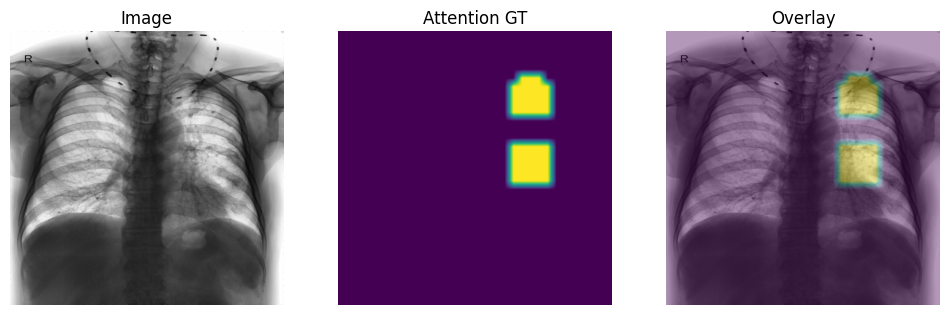

In [77]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

grid_size = 32
img_size = 512

# ----- Convert image -----
img_np = pixel_values.permute(1, 2, 0).cpu().numpy()

# SigLIP images are normalized → rescale for display
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-6)

# ----- Convert attention -----
att_map = attn_gt.reshape(grid_size, grid_size)

att_map = F.interpolate(
    att_map.unsqueeze(0).unsqueeze(0),
    size=(img_size, img_size),
    mode="bilinear",
    align_corners=False
).squeeze().cpu().numpy()

# ----- Plot -----
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(att_map)
plt.title("Attention GT")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_np)
plt.imshow(att_map, alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.show()

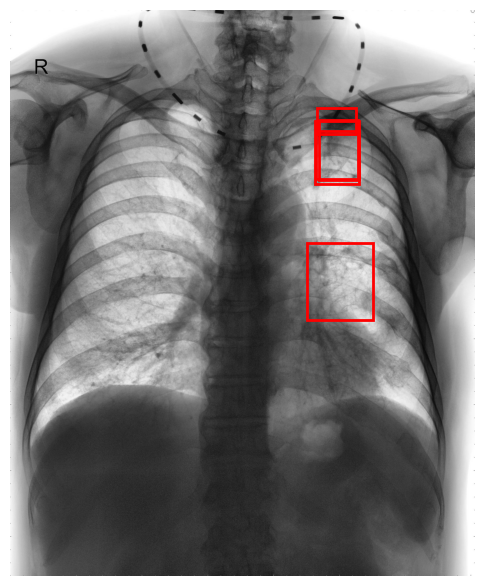

In [79]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

img_path = '/home/jupyter-nafisha/Data/data_v3_CLAHE/vinbig/a7ae31b4052444b8f576b657b1753445.jpg'
json_path = '/home/jupyter-nafisha/Data/data_v3_CLAHE/annotations/vinbig/a7ae31b4052444b8f576b657b1753445.json'

# Load image
img = Image.open(img_path).convert("RGB")

# Load annotations
with open(json_path, "r") as f:
    data = json.load(f)

objects = data["objects"]

# Plot
fig, ax = plt.subplots(1, figsize=(6, 8))
ax.imshow(img)

for obj in objects:

    (x_min, y_min), (x_max, y_max) = obj["points"]["exterior"]
    disease = obj["points"].get("disease", "Unknown")

    width = x_max - x_min
    height = y_max - y_min

    rect = patches.Rectangle(
        (x_min, y_min),
        width,
        height,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )

    ax.add_patch(rect)

    # ax.text(
    #     x_min,
    #     y_min - 5,
    #     disease,
    #     color='red',
    #     fontsize=8,
    #     backgroundcolor='white'
    # )

ax.axis("off")
plt.show()